## Class 8 Agenda:
  * **Feature Engineering: Standard Scaling/MinMaxScaling**
  * **Feature Engineering: Handling Categorical Features**
  * **Feature Engineering: Handling Missing Values**
  * **Feature Engineering: Creating Derived Features - Polynomial Features**
  * **Cross Validation vs. Train/Test Split**
  * **Cross Validation for Parameter Tuning**
  * **Searching over Parameters using GridSearchCV**

We are going to make a big step today in the sophistication and kinds of models we will be capable of building. We will talk about several common feature transformations that you can/should perform when preparing most data for machine learning models.

We're also going to learn how to improve the evaluation of the performance of any supervised machine learning models we build using a much better (more accurate) method than train-test split, one that gives more reliable estimates of error on unseen data.

#### Outcomes
By the end of this lesson you will be able to:
- articulate why feature scaling is important, and be able to do it using sklearn
- use a variety of transformation methods to reduce non-normality in features
- handle categorical features when building a machine learning model
- handle null/missing values when building a machine learning model
- use cross validation to accurately estimate model performance
- articulate the strengths and weaknesses of basic cross validation
- use cross validation to choose optimal model parameters by searching across many models simultaneously

### Feature Engineering

When we talk about feature engineering, we are really talking about two things:
* transforming the values at our disposal into a representation that a given machine learning algorithm can use and understand
* creating new, derived features from the available features (using domain expertise) and use them when training a model
* dealing with missing values, as most ML algorithms can't handle unknown values. They must be filled in.

We will begin with the first case, transformation, and talk about the three most common transformations necessary to get data into a state where it can be used to train most ML models:
* **feature scaling**: making it so that all columns (features) range over the same values is very helpful for many (but not all) machine learning models. In some cases, scaling along samples is useful, as well.
* **turning categorical values into numerical values**: machine learning algorithms only understand numbers, not categories.
* **handling missing values**: Models break when you give them `NaN`s, what are some strategies to replace `NaN`s with "good" (i.e. useful) numbers?

Let's import the basics (those things we've seen in the past) like always, and generate some fake data:

In [1]:
from __future__ import print_function, division  # Python 2/3

In [2]:
#data handling, model creation/evaluation
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy import stats

#make it so that we only show first 4 decimals for floats
np.set_printoptions(precision=4,suppress=True)

# visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# fake data
train = pd.DataFrame({'target':[0,1,2], 'length':[0.9,0.3,0.6], 'mass':[0.1,0.2,0.8], 'rings':[40,50,60]})
test = pd.DataFrame({'length':[0.59], 'mass':[0.79], 'rings':[54.9]})

## Feature Scaling

## Standardization:
Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.

For instance, many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the l1 and l2 regularizers of linear models) assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.


### Scaling to a range: MinMax Scaler
simplest method is to rescale the feature range to [0,1] or [-1, 1]  
\begin{equation}
X^\prime = \frac{X - min(X)}{max(X) - min(X)}
\end{equation}

### Scaling to zero mean, unit variance: Standard Scaler 
calculating the z-score rescale to zero mean and unit variance
\begin{equation}
X^\prime = \frac{X - \bar{X}}{\sigma}
\end{equation}

### Scaling to unit length: Normalization
rescale to unit length: useful in vector space models
\begin{equation}
X^\prime = \frac{X}{\left|\left| X \right| \right|}
\end{equation}


Note: save the scaler object that was applied on the training set, to be later re-applied on the testing set



Let's try to predict the `id` of each sample using the `length`, `mass`, and `rings` columns without doing any feature scaling:

In [4]:
# define X and y
feature_cols = ['length', 'mass', 'rings']
X = train[feature_cols]
y = train.target

To demonstrate this, we are going to be using a different classifier from the one's we've learned about so far. 

This algorithm is called [K-nearest-neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) and simply selects either the category (classification) or average of the K closest samples to it (computed using Euclidean distance).

We are going to use K-nearest-neighbors where k=1 (the single nearest neighbor, so it will simply assume the output of that sample):

In [5]:
# KNN with k=1
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

print("Training data:\n",train,"\n")
print("Single test sample:\n",test)

Training data:
    length  mass  rings  target
0     0.9   0.1     40       0
1     0.3   0.2     50       1
2     0.6   0.8     60       2 

Single test sample:
    length  mass  rings
0    0.59  0.79   54.9


**what id "should" the classifier predict?**

Hopefully, you said id 2.

In [6]:
print("Prediction: ",knn.predict(test))

Prediction:  [1]


The classifier predicts id `1` instead of id `2` because the portion of the distance in the `rings` column **dominates** all of the other distances (it varies over ~10 units, whereas both of the other features vary over ~1 unit).

How to get around this?

**You scale all of the features so that they all range over the same values.**

There are lots of ways to do this, we will talk about/use **Standard Scaling**. 

We simply compute the mean and standard deviation of each column, and for every value, subtract the mean of that column from the value, and divide by the standard deviation:
$$zscore(x_i)=\frac {x_i-\mu}{\sigma}$$

Let's do that using `sklearn`'s `StandardScaler`:

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # create a scaler object
scaler.fit(X) # fit the scaler
X_scaled = scaler.transform(X) #transform the data with it

# compare original to standardized
print("original values:\n",X.values,"\n")
print("scaled values:\n",X_scaled,"\n")

# figure out how the standardization worked
print("Mean of each column:\n",scaler.mean_,"\n")
print("standard deviation of each column:\n",scaler.scale_,"\n")
print("Z-scoring the values by hand to make sure we arent crazy:\n",(X.values - scaler.mean_) / scaler.scale_)
print("Final Means of scaled data, per column:\n",X_scaled.mean(axis=0))
print("Final SD's of scaled data, per column:\n",X_scaled.std(axis=0))

original values:
 [[  0.9   0.1  40. ]
 [  0.3   0.2  50. ]
 [  0.6   0.8  60. ]] 

scaled values:
 [[ 1.2247 -0.8627 -1.2247]
 [-1.2247 -0.5392  0.    ]
 [ 0.      1.4018  1.2247]] 

Mean of each column:
 [  0.6      0.3667  50.    ] 

standard deviation of each column:
 [ 0.2449  0.3091  8.165 ] 

Z-scoring the values by hand to make sure we arent crazy:
 [[ 1.2247 -0.8627 -1.2247]
 [-1.2247 -0.5392  0.    ]
 [ 0.      1.4018  1.2247]]
Final Means of scaled data, per column:
 [ 0. -0.  0.]
Final SD's of scaled data, per column:
 [ 1.  1.  1.]


You can also scale the data to an arbitrary range of values (instead of scaling them to have 0 mean and unit variance), we specify the minimum and maximum values that the column can take on, using `MinMaxScaler`. By default, `MinMaxScaler` scales the data to the range (0,1):

In [8]:
from sklearn.preprocessing import MinMaxScaler
minmax= MinMaxScaler()

minmax.fit(X) #fit the scaler
X_scaled_minmax = minmax.transform(X) #transform the data with it

# compare original to standardized
print("original values:\n",X.values,"\n")
print("scaled values:\n",X_scaled_minmax,"\n")

print("min and max of scaled values:\n",X_scaled_minmax.min(),"\n",X_scaled_minmax.max())
print("Mean of min/max scaled columns:\n", X_scaled_minmax.mean(axis=0))
print("Std of min/max scaled columns:\n", X_scaled_minmax.std(axis=0))

original values:
 [[  0.9   0.1  40. ]
 [  0.3   0.2  50. ]
 [  0.6   0.8  60. ]] 

scaled values:
 [[ 1.      0.      0.    ]
 [ 0.      0.1429  0.5   ]
 [ 0.5     1.      1.    ]] 

min and max of scaled values:
 0.0 
 1.0
Mean of min/max scaled columns:
 [ 0.5    0.381  0.5  ]
Std of min/max scaled columns:
 [ 0.4082  0.4416  0.4082]


Other scaling approaches may be more appropriate in different circumstances, you can read about them here: [preprocessing and scaling data in scikit-learn](http://scikit-learn.org/stable/modules/preprocessing.html)

One thing that is very important to keep in mind when scaling: 

**When you're creating a scaling object, you should first "fit" it to the training data, then transform both the training and testing data using the "fit" scaler. If you try to fit the training and testing data separately, you will get inaccurate results.**

(Why?)

### UCI Wine Dataset

In [9]:
df = pd.io.parsers.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
     header=None,
     usecols=[0,1,2]
    )

df.columns=['Class label', 'Alcohol', 'Malic acid']

df.head()

,Class label,Alcohol,Malic acid
0,1,14.23,1.71
1,1,13.20,1.78
2,1,13.16,2.36
3,1,14.37,1.95
4,1,13.24,2.59


As we can see in the table above, the features **Alcohol (percent/volumne)** and **Malic acid (g/l)** are measured on different scales, so that **Feature Scaling** is necessary and an important prior to any comparison or combination of these data.

In [10]:
std_scale = preprocessing.StandardScaler().fit(df[['Alcohol', 'Malic acid']])
df_std = std_scale.transform(df[['Alcohol', 'Malic acid']])

minmax_scale = preprocessing.MinMaxScaler().fit(df[['Alcohol', 'Malic acid']])
df_minmax = minmax_scale.transform(df[['Alcohol', 'Malic acid']])

In [11]:
print('Mean after standardization:\nAlcohol={:.2f}, Malic acid={:.2f}'
      .format(df_std[:,0].mean(), df_std[:,1].mean()))
print('\nStandard deviation after standardization:\nAlcohol={:.2f}, Malic acid={:.2f}'
      .format(df_std[:,0].std(), df_std[:,1].std()))

Mean after standardization:
Alcohol=-0.00, Malic acid=-0.00

Standard deviation after standardization:
Alcohol=1.00, Malic acid=1.00


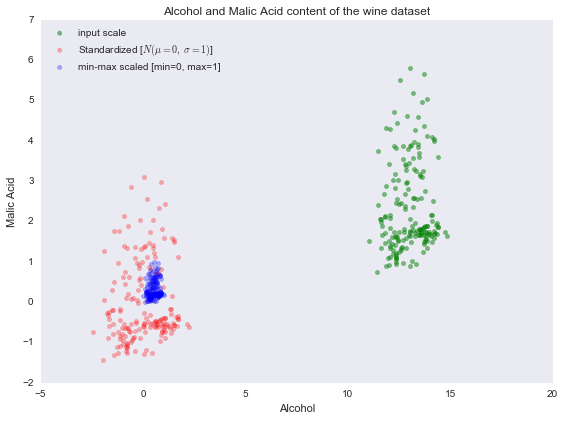

In [12]:
def plot():
    plt.figure(figsize=(8,6))

    plt.scatter(df['Alcohol'], df['Malic acid'],
            color='green', label='input scale', alpha=0.5)

    plt.scatter(df_std[:,0], df_std[:,1], color='red',
            label='Standardized [$ N  (\mu=0, \; \sigma=1) $]', alpha=0.3)
    
    plt.scatter(df_minmax[:,0], df_minmax[:,1],
        color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.title('Alcohol and Malic Acid content of the wine dataset')
    plt.xlabel('Alcohol')
    plt.ylabel('Malic Acid')
    plt.legend(loc='upper left')
    plt.grid()

    plt.tight_layout()

plot()
plt.show()

#### Exercise Time!!!

* load in the wine data located [here](http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data). The columns for the data are as follows:
    1. Label
    2. Alcohol
    3. Malic acid
    4. Ash
    5. Alcalinity of ash  
    6. Magnesium
	7. Total phenols
    8. Flavonoids
    9. Nonflavanoid phenols
    10. Proanthocyanins
    11. Color intensity
    12. Hue
    13. OD280/OD315 of diluted wines
    14. Proline
    
* build a knn model with 3 nearest neighbors to predict the wine's `label` from the remaining columns. Don't scale the data, and check the test error when using 80/20 train/test split. (use `KNeighborsClassifier(n_neighbors=3)`)
* now, build the same model, with the same train/test split, but scale the data using `StandardScaler` and `MinMaxScaler`. What is the test error for each of these scaled datasets (for `train_test_split use random_state=1234` for reproducibility)? 

In [14]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
column_names = ["label","alcohol","malic","ash","ash_alcalinity","magnesium","total_phenols",
                "flavonoids","nonflavonoids","proanth","color","hue","dilute","proline"]
wine_features = column_names[1:]
wine_target = column_names[0]
wine_data = pd.read_csv(url,names=column_names)
wine_data.head()

,label,alcohol,malic,ash,ash_alcalinity,magnesium,total_phenols,flavonoids,nonflavonoids,proanth,color,hue,dilute,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [15]:
#your code below here

### Handling Categorical Features

scikit-learn expects all features to be numeric. So how do we include categorical columns (features) in our model? Before we decide how to encode categorical features, we need to understand the kind of categorical features we have:

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding

We will look at one case of unordered categorical columns here:
- **unordered categories with more than 2 levels**

Let's work with another dataset from the UCI ML repository, the [abalone dataset](http://archive.ics.uci.edu/ml/datasets/Abalone), which contains 9 columns:
1. **Sex:** M, F, and I (infant)
2. **Length:** Longest shell measurement
3. **Diameter:** Perpendicular to length
4. **Height:** Height with with meat in shell
5. **Whole weight:** Whole abalone weight
6. **Shucked weight:** Weight of meat only
7. **Viscera weight:** Gut weight (after bleeding)
8. **Shell weight:** Weight after being dried
9. **Rings:** This value +1.5 gives the abalone's age in years

In [16]:
columns = ["sex","length","diam","height","whole","shucked","viscera","shell","age"]
abalone_data = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data",names=columns)
abalone_data.head()

,sex,length,diam,height,whole,shucked,viscera,shell,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


How do we include an unordered categorical feature with more than two levels, like **sex**? We can't simply encode it as F=1, I=2, M=3, because that would imply an **ordered relationship** in which I is somehow "double" F and M is somehow "triple" F.

Instead, we create **additional dummy variables** and append them to the original dataset:

In [17]:
sex_dummies = pd.get_dummies(abalone_data.sex).astype(int)
sex_dummies.head()

,F,I,M
0,0,0,1
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0


However, we actually only need **two dummy variables, not three**. Why? Because two dummies capture all of the "information" about the **sex** feature, and implicitly defines M as the **baseline level** (0 for both F and I implies M):

In [18]:
sex_dummies = sex_dummies[["F","I"]]
sex_dummies.head()

,F,I
0,0,0
1,0,0
2,1,0
3,0,0
4,0,1


Here is how we interpret the encoding:

- F is encoded as F=1 and I=0
- I is encoded as F=0 and I=1
- M is encoded as F=0 and I=0

If this is confusing, think about why we only needed one dummy variable for a hypothetical binary categorical variable, not two dummy variables. In general, if you have a categorical feature with **k levels** (k distinct values that it takes on), you create **k-1 dummy variables**.

Let's reappend these features to the original abalone dataset and drop the original `sex` column:

In [19]:
abalone_data = pd.concat([abalone_data,sex_dummies],axis=1) #remember that concatenating columns means axis=1!
abalone_data.drop("sex",inplace=True,axis=1)
abalone_data.head()

,length,diam,height,whole,shucked,viscera,shell,age,F,I
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1


### Handling missing values

scikit-learn models expect that all values are **numeric types** and **hold some meaning**. Thus, missing values are not allowed by scikit-learn (or by most machine learning algorithms).

Let's use an example dataset that contains missing values to explore some strategies for how they can be handled. This dataset is called the [Chronic Kidney Disease Dataset](https://archive.ics.uci.edu/ml/datasets/Chronic_Kidney_Disease) and can be used to create a model that predicts whether someone has CKD (chronic kidney disease) or not.

The columns in the dataset are as follows:

* **age**: subject age, numeric
* **bp**: blood pressure,  numeric
* **sg**: specific gravity, numeric but discrete
* **al**: albumin, numeric but discrete
* **su**: sugar, numeric but discrete
* **rbc**: red blood cells, categorical
* **pc**: pus cell, categorical 
* **pcc**: pus cell clumps, categorical
* **ba**: bacteria, categorical
* **bgr**: blood glucose random, numeric
* **bu**: blood urea, numeric
* **sc**: serum creatinine, numeric 
* **sod**: sodium, numeric 
* **pot**: potassium, numeric 
* **hemo**: hemoglobin, numeric
* **pcv**: packed cell volume, numeric
* **wc**: white blood cell count, numeric
* **rc**: red blood cell count, numeric
* **htn**: hypertension, categorical
* **dm**: diabetes mellitus, categorical 
* **cad**: coronary artery disease, categorical
* **appet**: appetite, categorical
* **pe**: pedal edema, categorical 
* **ane**: anemia, categorical
* **class**: class, categorical

Let's load the data in:

In [20]:
kidney_columns = ["age","bp","sg","al","su","rbc","pc","pcc","ba","bgr","bu","sc","sod","pot","hemo","pcv","wc","rc","htn","dm","cad","appet","pe","ane","class"]
kidney_data = pd.read_csv("../data/chronic_kidney_disease.csv", header=None,names=kidney_columns)
kidney_data.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,...,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


So it looks like any cell with a missing value is marked with a `?`.

Let's make **pandas** recognize that by specifying the `NaN` value type by passing in `?` into the `na_values` parameter of `read_csv`:

In [21]:
kidney_data = pd.read_csv("../data/chronic_kidney_disease.csv",header=None,na_values="?",names=kidney_columns)
kidney_data.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


Now let's look at which cells have `NaN`'s in them by calling `isnull()` on the `kidney_data` `DataFrame`:

In [22]:
kidney_data.isnull().head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Let's check the total number of rows missing values per column:

In [23]:
# check for number of missing values per column
kidney_data.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wc       106
rc       131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

We are going to have to handle the categorical and the numeric columns differently:

In [24]:
kidney_data.dtypes

age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wc       float64
rc       float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
class     object
dtype: object

Let's rearrange the numeric and categorical columns for easier access later, and lets remove the response column (`class`) into a separate `Series`:

In [25]:
print("column names before rearranging:\n",kidney_columns)
kidney_columns = kidney_columns[:5]+kidney_columns[9:18]+kidney_columns[5:9]+kidney_columns[18:]
print("column names after rearranging:\n",kidney_columns)

column names before rearranging:
 ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']
column names after rearranging:
 ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']


In [26]:
kidney_data = kidney_data[kidney_columns]
target = kidney_data["class"]
print(kidney_data.dtypes)
kidney_data.head()

age      float64
bp       float64
sg       float64
al       float64
su       float64
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wc       float64
rc       float64
rbc       object
pc        object
pcc       object
ba        object
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
class     object
dtype: object


,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,normal,notpresent,notpresent,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,normal,notpresent,notpresent,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,normal,notpresent,notpresent,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,abnormal,present,notpresent,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,normal,notpresent,notpresent,no,no,no,good,no,no,ckd


Ok, now that our data is arranged in a way that's amenable with dealing with the numeric and the categorical columns separately, let's work through the ways in which we can handle null values.

The first thing we can do, is simply throw out any samples that have nulls in any column:

In [27]:
kidney_data_nonnull = kidney_data.dropna()
print("Fraction of data kept:\n",float(kidney_data_nonnull.shape[0])/kidney_data.shape[0])

Fraction of data kept:
 0.395


So throwing out ~60% of the data is no bueno. What else can we do?

We can **impute** (fill in) the data on a per-column basis. The imputation strategy for categorical columns is usually one of the following:
  1. fill in with the most common categorical value
  2. fill in with a special "missing" category

Let's do each in turn.

Here's how we would do **1.**

We are going to get the most common category per column, and store it in a `Series` first, then we will apply it per-column to those columns:

In [28]:
#function to return the most frequent value in a pandas Series
def get_most_frequent_value(my_column):
    return my_column.value_counts().index[0]

most_frequent_values_per_column = kidney_data[kidney_columns[14:-1]].apply(get_most_frequent_value,axis=0)
print("Most frequent value in each column:\n",most_frequent_values_per_column)

Most frequent value in each column:
 rbc          normal
pc           normal
pcc      notpresent
ba       notpresent
htn              no
dm               no
cad              no
appet          good
pe               no
ane              no
dtype: object


In [29]:
categorical_most_frequent = kidney_data[kidney_columns[14:-1]].fillna(most_frequent_values_per_column,axis=0)
categorical_most_frequent.head()

,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane
0,normal,normal,notpresent,notpresent,yes,yes,no,good,no,no
1,normal,normal,notpresent,notpresent,no,no,no,good,no,no
2,normal,normal,notpresent,notpresent,no,yes,no,poor,no,yes
3,normal,abnormal,present,notpresent,yes,no,no,poor,yes,yes
4,normal,normal,notpresent,notpresent,no,no,no,good,no,no


Now let's do **2.** (Which is much easier):

In [30]:
special_missing_category = kidney_data[kidney_columns[14:-1]].fillna("missing")
special_missing_category.head()

,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane
0,missing,normal,notpresent,notpresent,yes,yes,no,good,no,no
1,missing,normal,notpresent,notpresent,no,no,no,good,no,no
2,normal,normal,notpresent,notpresent,no,yes,no,poor,no,yes
3,normal,abnormal,present,notpresent,yes,no,no,poor,yes,yes
4,normal,normal,notpresent,notpresent,no,no,no,good,no,no


For numerical columns, there are 3 common strategies for filling in missing values:

1. Fill in using the mean
2. Fill in using the median (when many outliers are present)
3. Fill in with some default value (e.g. 0).

Let's do each in turn:

In [31]:
#1.
print("Lots of missing data here:\n",kidney_data[kidney_columns[:14]].head())
mean_per_column = kidney_data[kidney_columns[:14]].apply(lambda x: x.mean(),axis=0)
print("Mean value per column:\n",mean_per_column)

Lots of missing data here:
     age    bp     sg   al   su    bgr    bu   sc    sod  pot  hemo   pcv  \
0  48.0  80.0  1.020  1.0  0.0  121.0  36.0  1.2    NaN  NaN  15.4  44.0   
1   7.0  50.0  1.020  4.0  0.0    NaN  18.0  0.8    NaN  NaN  11.3  38.0   
2  62.0  80.0  1.010  2.0  3.0  423.0  53.0  1.8    NaN  NaN   9.6  31.0   
3  48.0  70.0  1.005  4.0  0.0  117.0  56.0  3.8  111.0  2.5  11.2  32.0   
4  51.0  80.0  1.010  2.0  0.0  106.0  26.0  1.4    NaN  NaN  11.6  35.0   

       wc   rc  
0  7800.0  5.2  
1  6000.0  NaN  
2  7500.0  NaN  
3  6700.0  3.9  
4  7300.0  4.6  
Mean value per column:
 age       51.483376
bp        76.469072
sg         1.017408
al         1.016949
su         0.450142
bgr      148.036517
bu        57.425722
sc         3.072454
sod      137.528754
pot        4.627244
hemo      12.526437
pcv       38.884498
wc      8406.122449
rc         4.707435
dtype: float64


In [32]:
#1. cont'd.
numeric_mean_filled = kidney_data[kidney_columns[:14]].fillna(mean_per_column,axis=0)
numeric_mean_filled.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
0,48.0,80.0,1.020,1.0,0.0,121.000000,36.0,1.2,137.528754,4.627244,15.4,44.0,7800.0,5.200000
1,7.0,50.0,1.020,4.0,0.0,148.036517,18.0,0.8,137.528754,4.627244,11.3,38.0,6000.0,4.707435
2,62.0,80.0,1.010,2.0,3.0,423.000000,53.0,1.8,137.528754,4.627244,9.6,31.0,7500.0,4.707435
3,48.0,70.0,1.005,4.0,0.0,117.000000,56.0,3.8,111.000000,2.500000,11.2,32.0,6700.0,3.900000
4,51.0,80.0,1.010,2.0,0.0,106.000000,26.0,1.4,137.528754,4.627244,11.6,35.0,7300.0,4.600000


In [33]:
#2.
print(kidney_data[kidney_columns[:14]].head())
median_per_column = kidney_data[kidney_columns[:14]].apply(lambda x: x.median(),axis=0)
print("Median per column:\n",median_per_column)

    age    bp     sg   al   su    bgr    bu   sc    sod  pot  hemo   pcv  \
0  48.0  80.0  1.020  1.0  0.0  121.0  36.0  1.2    NaN  NaN  15.4  44.0   
1   7.0  50.0  1.020  4.0  0.0    NaN  18.0  0.8    NaN  NaN  11.3  38.0   
2  62.0  80.0  1.010  2.0  3.0  423.0  53.0  1.8    NaN  NaN   9.6  31.0   
3  48.0  70.0  1.005  4.0  0.0  117.0  56.0  3.8  111.0  2.5  11.2  32.0   
4  51.0  80.0  1.010  2.0  0.0  106.0  26.0  1.4    NaN  NaN  11.6  35.0   

       wc   rc  
0  7800.0  5.2  
1  6000.0  NaN  
2  7500.0  NaN  
3  6700.0  3.9  
4  7300.0  4.6  
Median per column:
 age       55.00
bp        80.00
sg         1.02
al         0.00
su         0.00
bgr      121.00
bu        42.00
sc         1.30
sod      138.00
pot        4.40
hemo      12.65
pcv       40.00
wc      8000.00
rc         4.80
dtype: float64


In [34]:
#2. cont'd.
numeric_median_filled = kidney_data[kidney_columns[:14]].fillna(median_per_column,axis=0)
numeric_median_filled.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,138.0,4.4,15.4,44.0,7800.0,5.2
1,7.0,50.0,1.020,4.0,0.0,121.0,18.0,0.8,138.0,4.4,11.3,38.0,6000.0,4.8
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,138.0,4.4,9.6,31.0,7500.0,4.8
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,138.0,4.4,11.6,35.0,7300.0,4.6


In [35]:
default_value_per_column = kidney_data[kidney_columns[:14]].fillna(0.0)
default_value_per_column.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,0.0,0.0,15.4,44.0,7800.0,5.2
1,7.0,50.0,1.020,4.0,0.0,0.0,18.0,0.8,0.0,0.0,11.3,38.0,6000.0,0.0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,0.0,0.0,9.6,31.0,7500.0,0.0
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,0.0,0.0,11.6,35.0,7300.0,4.6


All of these imputation methods will have distinct effects on classification accuracy.

Much fancier methods for imputing values, including [EM (expectation maximization)](https://en.wikipedia.org/wiki/Expectation–maximization_algorithm), [multiple imputation](https://en.wikipedia.org/wiki/Imputation_%28statistics%29), etc. exist. 

These fancy imputation methods attempt to preserve the statistical relationships among the variables, and "fill in" the most likely values, given the values of all of the other columns (these are "distributional" imputation methods, as they attempt to keep the distributions of the columns as similar as possible after imputation to what they were prior to imputation). 

**However, they give really unstable/unreliable results when you have lots of missing data (>10% missing values), so I don't recommend using them when you have a dataset that is missing lots of values.**

Look into these to find out more.

#### Exercise Time!!!

1. Create a complete, filled in dataset of non-missing values using mean imputation per numeric column, most frequent value imputation for the categorical values, convert all of the categorical columns into numerical columns using `get_dummies`
2. Do the same thing using median imputation for each numeric column.
3. Compare test set errors when building a Logistic Regression model (`LogisticRegression()`) on the data and using train/test split (`train_test_split(random_state=123)`), predicting the `class` column. Which imputation method seems to perform better on this dataset?

In [36]:
pass

### Generating higher-order features: Polynomial Transformation

Although some machine learning methods, like **Random Forests** implicitly model non-linear interactions between the features in your data, it can be helpful to generate the full complement of non-linear interaction terms quickly. A simple and common method to use is polynomial features, which can generate features’ higher-order and interaction terms.

Let's take a look at the kidney data, so we can see how this can be done in practice using the preprocessing function `PolynomialFeatures`. Let's first fill in all of the nulls, then go forward with the exploration:

In [37]:
kidney_data_numeric_columns = kidney_data.columns.tolist()[:14]
kidney_data_categorical_columns = kidney_data.columns.tolist()[14:-1]
kidney_data_filled = kidney_data.copy()
kidney_data_filled[kidney_data_numeric_columns] = numeric_median_filled
kidney_data_filled[kidney_data_categorical_columns] = categorical_most_frequent
kidney_data_filled.isnull().sum()

age      0
bp       0
sg       0
al       0
su       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wc       0
rc       0
rbc      0
pc       0
pcc      0
ba       0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
class    0
dtype: int64

In [38]:
from sklearn.preprocessing import PolynomialFeatures
poly_fit = PolynomialFeatures(degree=3)
fitted_degree3_numeric_kidneys = poly_fit.fit_transform(kidney_data_filled[kidney_data_numeric_columns])

Let's take a look at the first few rows in this data:

In [39]:
fitted_degree3_numeric_kidneys[:5]

array([[  1.0000e+00,   4.8000e+01,   8.0000e+01, ...,   3.1637e+08,
          2.1091e+05,   1.4061e+02],
       [  1.0000e+00,   7.0000e+00,   5.0000e+01, ...,   1.7280e+08,
          1.3824e+05,   1.1059e+02],
       [  1.0000e+00,   6.2000e+01,   8.0000e+01, ...,   2.7000e+08,
          1.7280e+05,   1.1059e+02],
       [  1.0000e+00,   4.8000e+01,   7.0000e+01, ...,   1.7507e+08,
          1.0191e+05,   5.9319e+01],
       [  1.0000e+00,   5.1000e+01,   8.0000e+01, ...,   2.4513e+08,
          1.5447e+05,   9.7336e+01]])

This transformation generates every possible pairwise combination of all of the numeric columns in the kidney dataset upto a degree of 3.

So, if we had 3 columns, $X,Y,Z$, this transformation would generate:
$$(1,X,Y,Z,XY,XZ,YZ,X^2,Y^2,Z^2,X^2Y,X^2Z,...,XYZ,X^3,Y^3,Z^3) $$

However, this is complete overkill. What we usually want to generate is just the interactions ($XY, YZ$,etc. terms) not all of the polynomial degrees. In that case, we simply pass an extra Boolean parameter to the `PolynomialFeatures` function:

In [40]:
poly_fit_3_interact = PolynomialFeatures(degree=3,interaction_only=True)
#don't want the initial constant term, so only keep columns 1 to the end
interactions_only_kidney_columns = poly_fit_3_interact.fit_transform(kidney_data_filled[kidney_data_numeric_columns])[:,1:]

#### Exercise Time!
1. Generate the interactions-only degree-2 polynomial-fit features for the kidney_data null-filled dataset on the numeric columns only.
2. Use train_test_split to predict the class with/without these polynomial features using `LogisticRegression()`. What happens to train/test accuracy?

In [41]:
pass

Now, we are going to talk about better ways to measure model performance than train/test split.

### Cross-validation as many train/test splits

We are going to motivate this discussion of cross-validation by trying to see if there are any drawbacks from just using train/test split. Specifically:
  - What is the drawback of using the **train/test split** procedure for model evaluation?
  - How does **K-fold cross-validation** overcome this limitation?

**Motivation:** We need a way to choose between several different machine learning models (or multiple versions of the same model). Our goal is **to estimate likely performance of a model on out-of-sample data**.

**Initial approach:** Train/test split
- Split the dataset into two pieces, so that the model can be trained and tested on **different data**.
- **Testing accuracy** is a better estimate than training accuracy of out-of-sample performance (because testing on the same data that you used to train the model causes **overfitting** and worse out-of-sample performance).
- However, just using one train/test split provides a **high variance** estimate since changing which observations happen to be in the testing set can significantly change testing accuracy.

What would be a better approach?

**Better approach:** Create a bunch of train/test splits, calculate the testing accuracy for each, and average the results together.

**This is the essense of cross-validation.**

### Cross-validation flow
1. Split the dataset into K **equal** partitions (or "folds").
2. Use fold 1 as the **testing set** and the union of the other folds as the **training set**.
3. Calculate **testing accuracy**.
4. Repeat steps 2 and 3 K times, using a **different fold** as the testing set each time.
5. Use the **average testing accuracy** as the estimate of out-of-sample accuracy.

**Here's an example diagram where K = 5 (5 fold cross-validation):**
![5-fold cross-validation](../images/5-fold-cv.png)

In [46]:
from sklearn.cross_validation import KFold, cross_val_score

In [47]:
# simulate splitting a dataset of 30 observations into 5 folds
kf = KFold(20, n_folds=5, shuffle=False)

# print the contents of each training and testing set
print('{} {:^74} {}'.format('Iteration', 'Training set observations', 'Testing set observations'))
for iteration, data in enumerate(kf, start=1):
    print('{} {} {}'.format(iteration, data[0], data[1]))

Iteration                         Training set observations                          Testing set observations
1 [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [0 1 2 3]
2 [ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19] [4 5 6 7]
3 [ 0  1  2  3  4  5  6  7 12 13 14 15 16 17 18 19] [ 8  9 10 11]
4 [ 0  1  2  3  4  5  6  7  8  9 10 11 16 17 18 19] [12 13 14 15]
5 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [16 17 18 19]


Let's go through this carefully:
- Dataset contains **30 observations** (numbered 0 through 29)
- 5-fold cross-validation, thus it runs for **5 iterations**
- For each iteration, every observation is either in the training set or the testing set, **but not both**
- Every observation is in the testing set **exactly once**

Let's try this with real data and compare to just a single train/test split (we will use the vertebral column data we've used before):

In [48]:
# read in the vertebral column data
vertebral_data = pd.read_csv("../data/vertebral_column_2_categories.dat", sep=" ",
                             names=["pelvic_incidence","pelvic_tilt","lumbar_lordosis_angle","sacral_slope","pelvic_radius","spondy_grade","outcome"])
#generate features, targets
X = vertebral_data.ix[:,:-1]
y = vertebral_data.outcome
rf = RandomForestClassifier(n_estimators=50) #random forest with 50 trees

#train/test split with 10% of data in each split:
kf = KFold(len(X), n_folds=10, shuffle=False)
kf_scores = []
for i, (train_idx, test_idx) in enumerate(kf):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
#     X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.1)
    rf_fit = rf.fit(X_train,y_train)
    score = metrics.accuracy_score(y_test,rf_fit.predict(X_test))
    print("Accuracy for split ",i,": ", score)
    kf_scores.append(score)

print("Mean KF-accuracy:",np.mean(kf_scores))
print("Std of KF-accuracy:",np.std(kf_scores))
    
#compute cross-validation score accuracy across 10 folds
cross_val_scores = cross_val_score(rf,X,y,cv=10)
print("10-fold accuracies:\n",cross_val_scores)
print("Mean cv-accuracy:",np.mean(cross_val_scores))
print("Std of cv-accuracy:",np.std(cross_val_scores))

Accuracy for split  0 :  0.451612903226
Accuracy for split  1 :  0.451612903226
Accuracy for split  2 :  0.967741935484
Accuracy for split  3 :  0.967741935484
Accuracy for split  4 :  1.0
Accuracy for split  5 :  1.0
Accuracy for split  6 :  0.967741935484
Accuracy for split  7 :  0.612903225806
Accuracy for split  8 :  0.677419354839
Accuracy for split  9 :  0.58064516129
Mean KF-accuracy: 0.767741935484
Std of KF-accuracy: 0.222463737414
10-fold accuracies:
 [ 0.6129  0.6129  0.7097  0.8065  0.9355  0.8387  0.9677  1.      0.8065
  0.871 ]
Mean cv-accuracy: 0.816129032258
Std of cv-accuracy: 0.129876271866


#### Exercise Time!!!

* Compute cross-validated mean/std of accuracies when doing 20, 40, 50-fold cross-validation using `cross_val_score()`. What happens to the mean and standard deviation of the accuracies as you increase the number of folds?

In [49]:
pass

Here are the advantages of **cross-validation:**
- More accurate estimate of out-of-sample accuracy
- More "efficient" use of data (every observation is used for both training and testing)

However, there are some advantages to using **train/test split:**
- Runs K times faster than K-fold cross-validation
- Simpler to examine the detailed results of the testing process

We can improve this basic cross-validation approach a bit more as follows:

**Repeated cross-validation**

- Repeat cross-validation multiple times (with **different random splits** of the data) and average the results
- More reliable estimate of out-of-sample performance by **reducing the variance** associated with a single trial of cross-validation

**Creating a hold-out set**

- "Hold out" a portion of the data **before** beginning the model building process
- Locate the best model using cross-validation on the remaining data, and test it **using the hold-out set**
- More reliable estimate of out-of-sample performance since hold-out set is **truly out-of-sample**

**Feature engineering and selection within cross-validation iterations**

- Normally, feature engineering and selection occurs **before** cross-validation
- Instead, you can perform all feature engineering and selection **within each cross-validation iteration**
- This gives us a more reliable estimate of out-of-sample performance since it **better mimics** the application of the model to out-of-sample data

In [50]:
from sklearn.model_selection import GridSearchCV

In [51]:
# use 10-fold cross-validation to find best max_depth per-tree out of depth 2 or 3

# try max_depth=2
rf_2 = RandomForestClassifier(max_depth=2, random_state=1)
print("Cross-validated mean accuracy for depth 2:",cross_val_score(rf_2, X, y, cv=10, scoring='accuracy').mean())

# try max_depth=3
rf_3 = RandomForestClassifier(max_depth=3, random_state=1)
print("Cross-validated mean accuracy for depth 3:",cross_val_score(rf_3, X, y, cv=10, scoring='accuracy').mean())

Cross-validated mean accuracy for depth 2: 0.761290322581
Cross-validated mean accuracy for depth 3: 0.787096774194


In [55]:
# use GridSearchCV to automate the search across depths 1-10
rf_grid = RandomForestClassifier(n_estimators=50,random_state=1,n_jobs=-1) #50 trees
max_depth_range = range(1, 20, 2)
param_grid = dict(max_depth=max_depth_range)
print(param_grid)
grid = GridSearchCV(rf_grid, param_grid, cv=3, scoring='accuracy')
grid.fit(X, y)

# store the results of the grid search
grid.grid_scores_
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]

{'max_depth': range(1, 20, 2)}


/Users/rameshsampath/miniconda2/envs/py35/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/rameshsampath/miniconda2/envs/py35/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


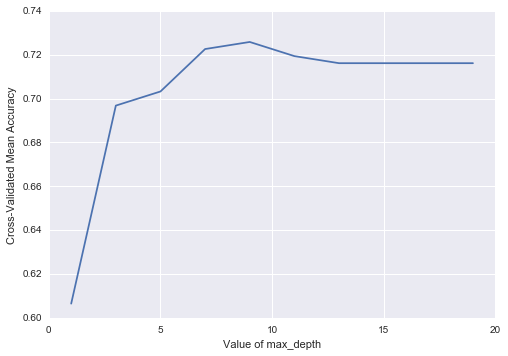

In [56]:
# plot the results
sns.plt.plot(max_depth_range, grid_mean_scores)
sns.plt.xlabel('Value of max_depth')
sns.plt.ylabel('Cross-Validated Mean Accuracy')

In [57]:
# what was best model?
grid.best_score_
grid.best_params_
grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [58]:
# search multiple parameters simultaneously
max_depth_range = range(1, 11)
leaf_range = range(1, 11)
param_grid2 = dict(max_depth=max_depth_range, min_samples_leaf=leaf_range)
grid = GridSearchCV(rf_grid, param_grid, cv=10, scoring='accuracy')
grid.fit(X, y)
grid.grid_scores_
grid.best_score_
grid.best_params_

/Users/rameshsampath/miniconda2/envs/py35/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


{'max_depth': 9}

#### Exercise Time!!!

I want you to use and test several different imputation methods, different feature transformations, and different model parameters using `GridSearchCV` for the kidney dataset.

This will get you to use everything we've learned today on one dataset with several kinds of missing values, and using both categorical and numeric values.

**Don't forget to transform the categories using `pd.get_dummies()` once you've filled in the missing data!**

Remember there are other parameters you can tune for random forests than just the maximum depth. Look at the random forest lesson or the [random forest documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

Try to be systematic in your exploration. Your goal is to make as robust a model as you can (lowest average cross-validated test error).

In [ ]:
pass